# 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.8.0 opencv-python matplotlib 

  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.10.0
    Uninstalling six-1.10.0:
      Successfully uninstalled six-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
texture 0.1.3 requires six==1.10.0, but you have six 1.16.0 which is incompatible.


# 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


# 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
POS_PATH

'data/positive'

In [7]:
NEG_PATH

'data/negative'

In [8]:
ANC_PATH

'data/anchor'

In [9]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Positives and Anchors

# 2.1 Untar Labelled Faces in the Wild Dataset

In [10]:
# http://vis-www.cs.umass.edu/lfw/

In [11]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tar

In [12]:
# Move lfw images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)        

In [13]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        print(os.path.join('lfw', directory, file))
        print(os.path.join(NEG_PATH, file))

# Collect Positive and Anchor Classes

In [14]:
# Import uuid labrary to generate unique image names
import uuid

In [15]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/489a2316-964b-11ec-b4ef-acde48001122.jpg'

In [16]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[160:160+250,550:550+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

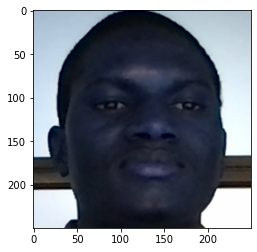

In [17]:
plt.imshow(frame)

# 3. Load and Preprocess Images

# 3.1 Get Image Directories

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg', shuffle=False).take(50)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg', shuffle=False).take(50)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg', shuffle=False).take(300)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
print(dir_test.next())

b'data/anchor/00153716-932b-11ec-8bc0-acde48001122.jpg'


# 3.2 Preprocessing - Scale and Resize

In [22]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100*p100*3
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1
    img = img / 255.0
    
    #Return image
    return img

In [23]:
img = preprocess('data/anchor/00153716-932b-11ec-8bc0-acde48001122.jpg')

In [24]:
img.numpy().max()

1.0

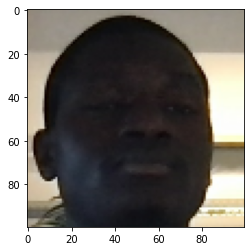

In [25]:
plt.imshow(img)

# 3.3 Create Labelled Dataset

In [26]:
# (anchor, positive) => 1, 1, 1, 1, 1
# (anchor, negative) => 0, 0, 0, 0, 0

In [27]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [28]:
iterator_labs = class_labels.as_numpy_iterator()

In [29]:
iterator_labs.next()

0.0

In [30]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [31]:
samples = data.as_numpy_iterator()

In [32]:
example = samples.next()

# 3.4 Build Train and Test Partition

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),  preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*example)

In [35]:
len(res)

3

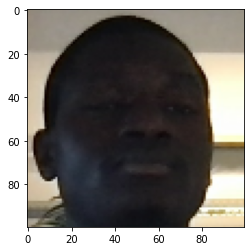

In [36]:
plt.imshow(res[0])

In [37]:
res[2]

1.0

In [38]:
#Build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [39]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [48]:
samples = data.as_numpy_iterator()

In [49]:
len(samples.next())

3

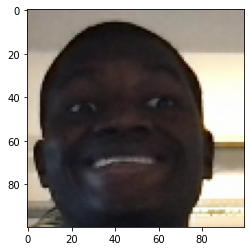

In [66]:
plt.imshow(samples.next()[0])

In [67]:
samp = samples.next()

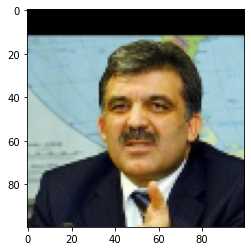

In [68]:
plt.imshow(samp[1])

In [69]:
samp[2]

0.0

In [70]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [71]:
train_samples = train_data.as_numpy_iterator()

In [72]:
train_samples = train_samples.next()

In [73]:
len((train_samples[0]))

16

In [74]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 1. Model Engineering

# 4.1 Build Embedding Layer

In [75]:
inp = Input(shape=(100,100,3), name='input_image')

In [76]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [77]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [78]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [79]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
        

In [80]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [81]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [82]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [83]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')




In [84]:
embedding = make_embedding()

In [85]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

# 4.2 Build distance Layer

In [86]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    # Magic happens here -similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [87]:
l1 = L1Dist()

# 4.3 Make Siamese Model

In [88]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [89]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [90]:
siamese_layer = L1Dist()

In [91]:
distances = siamese_layer(inp_embedding, val_embedding)

In [92]:
classifier = Dense(1, activation='sigmoid')(distances)

In [93]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [94]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [95]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [96]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [97]:
siamese_model = make_siamese_model()

In [98]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training
 

# 5.1 Setup Loss and Optimizer

In [99]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [100]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# 5.2 Establish Checkpoints

In [101]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_mode=siamese_model)

# 5.3 Build Train Step Function

In [102]:
test_batch = train_data.as_numpy_iterator()

In [103]:
batch_1 = test_batch.next()

In [104]:
X = batch_1[:2]

In [105]:
y = batch_1[2]

In [106]:
y

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [107]:
tf.losses.BinaryCrossentropy??

In [108]:
@tf.function
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label 
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate update weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

# 5.4 Build Training Loop

In [109]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [110]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train the Model

In [111]:
EPOCHS = 50

In [112]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 144s 27s/step
0.6798668 0.54285717 1.0

 Epoch 2/50
5/5 [==============================] - 125s 24s/step
0.37721822 0.64705884 1.0

 Epoch 3/50
5/5 [==============================] - 124s 25s/step
0.21865964 0.9705882 1.0

 Epoch 4/50
5/5 [==============================] - 148s 29s/step
0.057555307 0.9714286 1.0

 Epoch 5/50
5/5 [==============================] - 159s 29s/step
0.002023006 1.0 1.0

 Epoch 6/50
5/5 [==============================] - 127s 24s/step
0.019864999 1.0 1.0

 Epoch 7/50
5/5 [==============================] - 140s 27s/step
0.040564258 1.0 1.0

 Epoch 8/50
5/5 [==============================] - 121s 24s/step
0.0027808242 1.0 1.0

 Epoch 9/50
5/5 [==============================] - 117s 23s/step
0.0040084627 1.0 1.0

 Epoch 10/50
5/5 [=============================

# 6. Evaluate Model

# 6.1 Import Metritcs

In [127]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# 6.2 Make Predictions

In [128]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [129]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.1669655e-09],
       [1.3283311e-09],
       [1.0000000e+00],
       [7.8916317e-05],
       [1.0000000e+00],
       [9.9998158e-01],
       [1.0533494e-08],
       [4.2522311e-06],
       [3.5190258e-08],
       [9.9999541e-01],
       [2.4736121e-08],
       [1.0000000e+00],
       [9.9983823e-01],
       [7.2521478e-09],
       [9.9999499e-01],
       [9.9999940e-01]], dtype=float32)

In [130]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]

In [131]:
y_true

array([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

# 6.3 Calculate Metrics

In [132]:
# Creating a metric object
m = Recall()

# Calculate the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [133]:
# Creating a metric object
m = Precision()

# Calcualte the recal value
m.update_state(y_true, y_hat)

# Return recall Result
m.result().numpy()

1.0

# 6.4 Viz Results

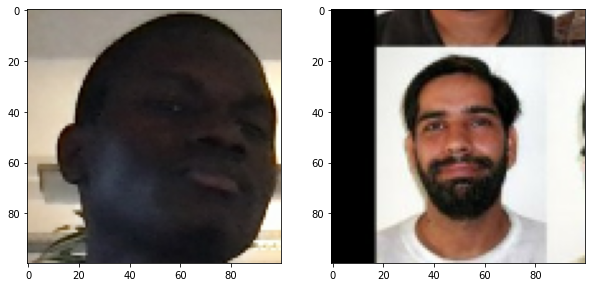

In [134]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly 
plt.show()

# 7. Save Model

In [135]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [136]:
L1Dist

__main__.L1Dist

In [137]:
 # Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [138]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[1.1669655e-09],
       [1.3283311e-09],
       [1.0000000e+00],
       [7.8916317e-05],
       [1.0000000e+00],
       [9.9998158e-01],
       [1.0533494e-08],
       [4.2522311e-06],
       [3.5190258e-08],
       [9.9999541e-01],
       [2.4736121e-08],
       [1.0000000e+00],
       [9.9983823e-01],
       [7.2521478e-09],
       [9.9999499e-01],
       [9.9999940e-01]], dtype=float32)

In [139]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test 

# 8.1 Verification Function 

In [140]:
os.listdir(os.path.join('application_data', 'verification_images')) 

['c954e990-92fa-11ec-b2c3-acde48001122.jpg',
 'fc806830-92fa-11ec-b2c3-acde48001122.jpg',
 'fe7f1b0e-92fa-11ec-b2c3-acde48001122.jpg',
 'd09f1a18-92fa-11ec-b2c3-acde48001122.jpg',
 'f02509ce-92fa-11ec-b2c3-acde48001122.jpg',
 'ff316ce6-92fa-11ec-b2c3-acde48001122.jpg',
 'd8a5aa06-92fa-11ec-b2c3-acde48001122.jpg',
 '.DS_Store',
 'fe58d976-92fa-11ec-b2c3-acde48001122.jpg',
 'f16fc06c-92fa-11ec-b2c3-acde48001122.jpg',
 'f9037440-92fa-11ec-b2c3-acde48001122.jpg',
 'd9b159c2-92fa-11ec-b2c3-acde48001122.jpg',
 'cad445ea-92fa-11ec-b2c3-acde48001122.jpg',
 'f61ed2a6-92fa-11ec-b2c3-acde48001122.jpg',
 'fdff3ab0-92fa-11ec-b2c3-acde48001122.jpg',
 'fffd8074-92fa-11ec-b2c3-acde48001122.jpg',
 'cbc7227e-92fa-11ec-b2c3-acde48001122.jpg',
 'f8c3d74a-92fa-11ec-b2c3-acde48001122.jpg',
 'cb53f60a-92fa-11ec-b2c3-acde48001122.jpg',
 'f3880288-92fa-11ec-b2c3-acde48001122.jpg',
 'f7de1dfe-92fa-11ec-b2c3-acde48001122.jpg',
 'f95d5c4e-92fa-11ec-b2c3-acde48001122.jpg',
 'fcfef614-92fa-11ec-b2c3-acde48001122.jp

In [141]:
os.path.join('application_data', 'input_image')

'application_data/input_image'

In [142]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/c954e990-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/fc806830-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/fe7f1b0e-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/d09f1a18-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/f02509ce-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/ff316ce6-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/d8a5aa06-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/.DS_Store
application_data/verification_images/fe58d976-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/f16fc06c-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/f9037440-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/d9b159c2-92fa-11ec-b2c3-acde48001122.jpg
application_data/verification_images/cad445ea-92fa-11ec-b2c3-acde48001122.jpg
application_data/

In [143]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# 8.2 OpenCV Real Time Verification

In [144]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[160:160+250,550:550+250, :]
    
    cv2.imshow('verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image'+'.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()